## Dog vs Cat Image Classification

### !!! Start from [Check Point](#Check Point) if data have beeen preprocessed and saved to disk when coming back to this notebook.

In [1]:
%matplotlib inline
import cv2, os, pickle
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split

print('All modules are imported.')

All modules are imported.


## 1. Preparing the Data

### 1.1 Explore the Data
#### Dataset statistics

In [2]:
# Image directoires
TRAIN_DIR = 'input/train/'
TEST_DIR = 'input/test/'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# print out statistics of the dataset and show example images
print("Stats of Dog_vs_Cat Train Dataset")
print("Total Images: {}".format(len(train_images)))
print("Dog:          {}".format(len([i for i in train_images if 'dog' in i ])))
print("Cat:          {}".format(len([i for i in train_images if 'cat' in i ])))
print('')
print('Stats of Dog_vs_Cat Test Dataset')
print('Total Images: {}'.format(len(test_images)))

Stats of Dog_vs_Cat Train Dataset
Total Images: 25000
Dog:          12500
Cat:          12500

Stats of Dog_vs_Cat Test Dataset
Total Images: 12500


#### Split train dataset (shuffle by default)

In [3]:
# Train validation split
# Validation set size is 1000, 4% of total train images
train_imgs, val_imgs = train_test_split(train_images, test_size=0.04, random_state=42)

print('Train Dataset is split, and shuffled randomly.')
print('Train Image:            {}'.format(len(train_imgs)))
print('Validation Image:       {}'.format(len(val_imgs)))
print('Train/Validation Ratio: {}/{}'.format(len(train_imgs)/len(train_images), len(val_imgs)/len(train_images)))

Train Dataset is split, and shuffled randomly.
Train Image:            24000
Validation Image:       1000
Train/Validation Ratio: 0.96/0.04


#### Display Example Images

Example of Train Image 100
Image - Shape: (417, 299, 3)
Image - Min Value: 0, Max Value: 255
Label - cat


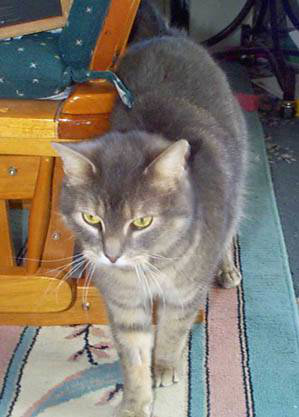

Example of Train Image 10000
Image - Shape: (374, 500, 3)
Image - Min Value: 0, Max Value: 255
Label - cat


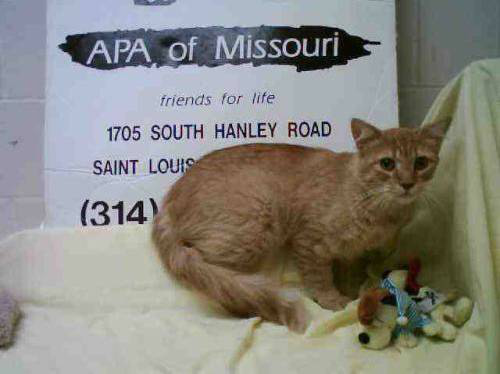

Example of Train Image 20000
Image - Shape: (251, 359, 3)
Image - Min Value: 0, Max Value: 255
Label - dog


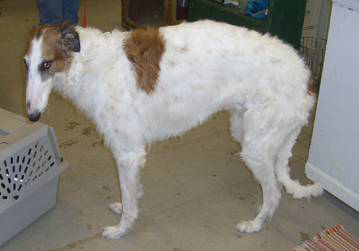

In [4]:
# Explore the dataset
image_id_list = [100, 10000, 20000]

for image_id in image_id_list:
    image_example = cv2.imread(train_imgs[image_id], cv2.IMREAD_COLOR)
    print("Example of Train Image {}".format(image_id))
    print("Image - Shape: {}".format(image_example.shape))
    print("Image - Min Value: {}, Max Value: {}".format(image_example.min(), image_example.max()))
    print("Label - {}".format('dog' if 'dog' in train_imgs[image_id] else 'cat'))
    display(Image.open(train_imgs[image_id]))

### 1.2 Define Preprocessing Functions
#### Resize images
The images have various sizes. So the first pre-processing step is to resize images.


In [5]:
def resize_image(list_img_dir, dsize=(64, 64, 3)):
    """
    Resizes images to the specified size, and return
    resized image pixels in shape: [imgs_num, row, column, channel]
    
    param list_img_dir: list of image directories.
    param dsize: (row, column, channel).
    """
    # Define specified sizes
    ROW = dsize[0]
    COL = dsize[1]
    CHANNEL = dsize[2]
    
    features = []
    # Resize the images
    for img in tqdm(list_img_dir, desc='Resize Images', unit='Images'):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.resize(img, dsize=(ROW, COL))
        features.append(img)
    
    features = np.array(features, dtype=np.uint8)
    
    print('Images are resized to: {}'.format(dsize))
    
    return features

Explore the resized example images

Resize Images: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.32Images/s]


Images are resized to: (224, 224, 3)
Resized Example Images

Example of Train Image 100
Image - Shape: (224, 224, 3)
Image - Min Value: 0, Max Value: 255
Label - cat


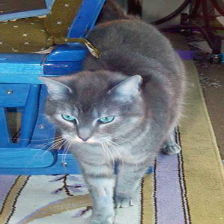


Resized Example Images

Example of Train Image 10000
Image - Shape: (224, 224, 3)
Image - Min Value: 0, Max Value: 244
Label - cat


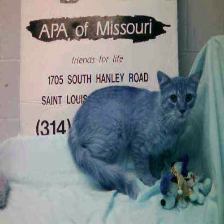


Resized Example Images

Example of Train Image 20000
Image - Shape: (224, 224, 3)
Image - Min Value: 0, Max Value: 236
Label - dog


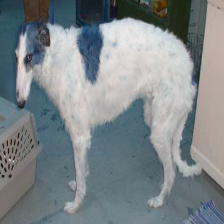

In [6]:
# Explore the resized image
example_features = resize_image([train_imgs[i] for i in image_id_list], dsize=(224, 224, 3))

#Show resized example images
for i, image_id in enumerate(image_id_list):
    print('Resized Example Images')
    print('')
    print("Example of Train Image {}".format(image_id))
    print("Image - Shape: {}".format(example_features[i].shape))
    print("Image - Min Value: {}, Max Value: {}".format(example_features[i].min(), example_features[i].max()))
    print("Label - {}".format('dog' if 'dog' in train_imgs[image_id] else 'cat'))
    display(Image.fromarray(example_features[i]))
    print('')

#### Normalize features

Normalize the image data with Min-Max scaling to a range of [0.0, 1.0].

In [7]:
def norm_image(features):
    """
    Normalize a list of image pixels with Min-Max scaling to a range of [0.0, 1.0].
    param featurs: image pixels in shape: [imgs_num, row, column, channel]
    return: Normalized image pixels
    """
    
    features = (features-0)/(255-0)
    print('Features are normalized to [0.0, 1.0] with Min-Max Scaling.')
    
    return features

#### One-Hot Encoding Labels

In [8]:
def one_hot_encode(list_img_dir):
    """
    One hot encode a list of sample labels.
    Return a one-hot enncoded vector for each label.
    """
    labels = [[0, 1] if 'cat' in i else [1, 0] for i in list_img_dir]
    labels = np.array(labels, dtype=np.float32)
    
    print('Labels are One-Hot Encoded.')
    
    return labels

#### Test ID

In [29]:
def test_id(list_img_dir):
    """
    Record ids for test data.
    """
    ids = [int(i.split('/')[2].split('.')[0]) for i in list_img_dir]
    
    print('Test Image Ids are obtained.')
    
    return ids

#### Save data

Save train/validation data.

In [10]:
def save_data(features, labels, filename):
    """
    Save Train/Validation Data to disk.
    """
    
    pickle_file = filename
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file...')
        try:
            with open(pickle_file, 'wb') as f:
                if 'train' in filename:
                    pickle.dump(
                        {
                            'train_features': features,
                            'train_labels': labels
                        }, f, pickle.HIGHEST_PROTOCOL)
                elif 'validation' in filename:
                    pickle.dump(
                        {
                            'valid_features': features,
                            'valid_labels': labels
                        }, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise

    print('Features and labels are cached in pickle file: {}.'.format(filename))

Save test data.

In [11]:
def save_test_data(features, ids, filename):
    """
    Save Test Data to disk.
    """
    pickle_file = filename
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file...')
        try:
            with open(pickle_file, 'wb') as f:
                pickle.dump(
                    {
                        'test_features': features,
                        'test_ids': ids
                    }, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise

    print('Features and IDs are cached in pickle file: {}'.format(filename))

### 1.3 Preprocessing Images

* Train/Validation Set: resize -> normalize -> one-hot encode -> save
* Test Set: resize  -> normalize -> save

Also be noted that the datasets will be split into chunks to run the preprocessing steps. 

We can't run the preprocessing steps for all image data at the same time, because this will run out of memory resources when image size is huge.

The computer is used has 32 GB RAM, and it succeeds to process all train images with (64x64x3) at the same time, but fails with (224x224x3).

In [105]:
# Preprocess and save data in chunks due to memory limit
chunk_size = 4096
image_size = (128, 128, 3)

for img_set_num, img_set in enumerate([train_imgs, val_imgs, test_images]):
    for i, start in enumerate(range(0, len(img_set), chunk_size)):
        # Set flags for feature engineering. This will prevent you from skipping on important step.
        is_features_resize = False
        is_features_normal = False
        is_labels_encod = False
        
        if img_set_num == 0: #Train Set
            pickle_file = 'preprocess_train_{}_{}_chunk_{}.p'.format(image_size[0], image_size[1], i)
        elif img_set_num == 1: # Validation Set
            pickle_file = 'preprocess_validation_{}_{}_chunk_{}.p'.format(image_size[0], image_size[1], i)
        else: # Test Set
            pickle_file = 'preprocess_test_{}_{}_chunk_{}.p'.format(image_size[0], image_size[1], i)
        
        if not os.path.isfile(pickle_file):
            end = min(start + chunk_size, len(img_set))
            images = img_set[start: end]
            
            features = resize_image(images, image_size)
            is_features_resize = True
            
            features = norm_image(features)
            is_features_normal = True
            
            if img_set_num == 0 or img_set_num == 1: #Train and Validation Set
                labels = one_hot_encode(images)
                is_labels_encod = True
                save_data(features, labels, pickle_file)
                
                assert is_features_resize, 'You skipped the step to resize the features'
                assert is_features_normal, 'You skipped the step to normalize the features'
                assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'
            
            else: # Test Set
                ids = test_id(images)
                save_test_data(features, ids, pickle_file)
                
                assert is_features_resize, 'You skipped the step to resize the features'
                assert is_features_normal, 'You skipped the step to normalize the features'

Resize Images: 100%|██████████████████████████████████████████████████████████| 4096/4096 [00:13<00:00, 303.33Images/s]


Images are resized to: (128, 128, 3)
Features are normalized to [0.0, 1.0] with Min-Max Scaling.
Test Image Ids are obtained.
Saving data to pickle file...
Features and IDs are cached in pickle file: preprocess_test_128_128_chunk_0.p


Resize Images: 100%|██████████████████████████████████████████████████████████| 4096/4096 [00:14<00:00, 284.96Images/s]


Images are resized to: (128, 128, 3)
Features are normalized to [0.0, 1.0] with Min-Max Scaling.
Test Image Ids are obtained.
Saving data to pickle file...
Features and IDs are cached in pickle file: preprocess_test_128_128_chunk_1.p


Resize Images: 100%|██████████████████████████████████████████████████████████| 4096/4096 [00:13<00:00, 298.96Images/s]


Images are resized to: (128, 128, 3)
Features are normalized to [0.0, 1.0] with Min-Max Scaling.
Test Image Ids are obtained.
Saving data to pickle file...
Features and IDs are cached in pickle file: preprocess_test_128_128_chunk_2.p


Resize Images: 100%|████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 249.95Images/s]


Images are resized to: (128, 128, 3)
Features are normalized to [0.0, 1.0] with Min-Max Scaling.
Test Image Ids are obtained.
Saving data to pickle file...
Features and IDs are cached in pickle file: preprocess_test_128_128_chunk_3.p


<a id='Check Point'></a>
## Check Point

If come back to this notebook or have to restart the notebook, start from here. The preprocessed data have been saved to disk.

In [1]:
%matplotlib inline

#Load the modules
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

print('All modules are imported.')

All modules are imported.


Reload preprocessed train and validation dataset from disk

In [2]:
preprocess_train_images = [i for i in os.listdir() if 'preprocess_train' in i]
feature_in_chunk = []
label_in_chunk = []
for preprocess_train in preprocess_train_images:
    with open(preprocess_train, 'rb') as f:
        pickle_chunk_data=pickle.load(f)
        feature_in_chunk.append(pickle_chunk_data['train_features'])
        label_in_chunk.append(pickle_chunk_data['train_labels'])
        del pickle_chunk_data

In [3]:
preprocess_valid_images = [i for i in os.listdir() if 'preprocess_validation' in i]
val_feature_in_chunk = []
val_label_in_chunk = []
for preprocess_valid in preprocess_valid_images:
    with open(preprocess_valid, 'rb') as f:
        pickle_chunk_data=pickle.load(f)
        val_feature_in_chunk.append(pickle_chunk_data['valid_features'])
        val_label_in_chunk.append(pickle_chunk_data['valid_labels'])
        del pickle_chunk_data

## Build the network

### Convolution Layer

In [4]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, conv_padding='SAME'):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :param conv_padding: 'SAME' or 'VALID'
    :param pool_padding: 'SAME' or 'VALID
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight =  tf.Variable(tf.random_normal(conv_ksize+(x_tensor.shape[-1].value,)+(conv_num_outputs,),
                                           stddev=0.05))
    bias = tf.Variable(tf.zeros([conv_num_outputs]))
    x = tf.nn.conv2d(x_tensor, weight, strides=(1,)+conv_strides+(1,), padding=conv_padding)
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.relu(x)

    return x 

### Convolution and Max Pooling Layer

In [5]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, conv_padding='SAME', pool_padding='SAME'):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :param conv_padding: 'SAME' or 'VALID'
    :param pool_padding: 'SAME' or 'VALID
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight =  tf.Variable(tf.random_normal(conv_ksize+(x_tensor.shape[-1].value,)+(conv_num_outputs,),
                                           stddev=0.05))
    bias = tf.Variable(tf.zeros([conv_num_outputs]))
    x = tf.nn.conv2d(x_tensor, weight, strides=(1,)+conv_strides+(1,), padding=conv_padding)
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=((1,)+ pool_ksize + (1,)),
                      strides=((1,)+ pool_strides + (1,)),
                      padding=pool_padding)
    return x 

### Flatten Layer

In [6]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    flatten_x = tf.reshape(x_tensor, 
                           shape=[tf.shape(x_tensor)[0], x_tensor.shape[1].value*x_tensor.shape[2].value*x_tensor.shape[3].value])
    return flatten_x

### Fully-Connected Layer

In [7]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal((x_tensor.shape[-1].value, num_outputs),
                                            stddev = 0.05))
    bias = tf.Variable(tf.zeros([num_outputs]))
    fc_x = tf.add(tf.matmul(x_tensor, weight), bias)
    fc_x = tf.nn.relu(fc_x)
    
    return fc_x

### Output Layer

In [8]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[-1].value,num_outputs],
                                            stddev=0.05))
    bias = tf.Variable(tf.zeros([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weight), bias)

### Create Convolution Model

In [9]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, conv_padding, pool_padding)
    #conv = conv2d(x, 64, (3, 3), (1, 1), conv_padding='SAME')
    conv = conv2d_maxpool(x, 64, (3, 3), (1, 1), (2, 2), (2, 2), conv_padding='SAME', pool_padding='VALID')
    conv = tf.nn.dropout(conv, keep_prob)
    #conv = conv2d(conv, 128, (3, 3), (1, 1), conv_padding='SAME')
    conv = conv2d_maxpool(conv, 128, (3, 3), (1, 1), (2, 2), (2, 2), conv_padding='SAME', pool_padding='VALID')
    conv = tf.nn.dropout(conv, keep_prob)
    conv = conv2d_maxpool(conv, 128, (3, 3), (1, 1), (2, 2), (2, 2), conv_padding='SAME', pool_padding='VALID')
    conv = tf.nn.dropout(conv, keep_prob)
    #conv = conv2d(conv, 256, (3, 3), (1, 1), conv_padding='SAME')
    conv = conv2d_maxpool(conv, 256, (3, 3), (1, 1), (2, 2), (2, 2), conv_padding='SAME', pool_padding='VALID')
    conv = tf.nn.dropout(conv, keep_prob)
    #conv = conv2d(conv, 512, (3, 3), (1, 1), conv_padding='SAME')
    conv = conv2d_maxpool(conv, 512, (3, 3), (1, 1), (2, 2), (2, 2), conv_padding='SAME', pool_padding='VALID')
    conv = tf.nn.dropout(conv, keep_prob)
    conv = conv2d_maxpool(conv, 512, (3, 3), (1, 1), (2, 2), (2, 2), conv_padding='SAME', pool_padding='VALID')
    conv = tf.nn.dropout(conv, keep_prob)
    
    # Function Definition from Above:
    #   flatten(x_tensor)
    flt = flatten(conv)
    flt = tf.nn.dropout(flt, keep_prob)

    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc = fully_conn(flt, 4096)
    fc = tf.nn.dropout(fc, keep_prob)
    fc = fully_conn(flt, 4096)
    fc = tf.nn.dropout(fc, keep_prob)

    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    # TODO: return output
    return output(fc, 2)

In [10]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

feature=feature_in_chunk[0]
label=label_in_chunk[0]

# Inputs
ROWS = feature.shape[1]
COLS = feature.shape[2]     #Resized image columns size
CHANNELS = feature.shape[3] #RGB channels
image_shape = (ROWS, COLS, CHANNELS)
n_classes = label.shape[1]
x = tf.placeholder(tf.float32, shape = (None, image_shape[0], image_shape[1], image_shape[2]), name='x')
y = tf.placeholder(tf.float32, shape = (None, n_classes), name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the Neural Network

#### Hyperparameters

In [11]:
# Tune Parameters
epochs = 100
batch_size = 128
val_batch_size = 64
keep_probability = 0.6

In [12]:
save_model_path = './dog_vs_cat'

train_loss = []
val_loss = []
train_acc = []
val_acc = []

print('Training...')
with tf.Session() as sess:
    #Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in tqdm(range(epochs), desc='Running Epochs', unit='Epoch'):
        # Loop over all batches
        train_batch_loss_total=0
        train_batch_acc_total=0 
        train_batch_count=0   
        
        for train_feature, train_label in zip(feature_in_chunk, label_in_chunk):
            for batch_start in range(0, train_feature.shape[0], batch_size):
                batch_end = min(batch_start + batch_size, train_feature.shape[0])
                feature_batch = train_feature[batch_start: batch_end]
                label_batch = train_label[batch_start: batch_end]

                sess.run(optimizer, feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })
            
                train_batch_loss_total += sess.run(cost, feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: 1.0
                })
                
                train_batch_acc_total += sess.run(accuracy, feed_dict={
                    x:feature_batch,
                    y:label_batch,
                    keep_prob: 1.0
                })
                train_batch_count += 1
        
        train_loss.append(train_batch_loss_total/train_batch_count)
        train_acc.append(train_batch_acc_total/train_batch_count)
    
    
        val_batch_loss_total = 0
        val_batch_acc_total = 0
        val_batch_count = 0
        
        
        for val_feature, val_label in zip(val_feature_in_chunk, val_label_in_chunk):   
            for val_batch_start in range(0, val_feature.shape[0], val_batch_size):
                val_batch_end = min(val_batch_start + val_batch_size, val_feature.shape[0])
                val_feature_batch = val_feature[val_batch_start:val_batch_end]
                val_label_batch = val_label[val_batch_start:val_batch_end]
        
                val_batch_loss_total += sess.run(cost, feed_dict={
                    x: val_feature_batch,
                    y: val_label_batch,
                    keep_prob: 1.
                })
        
                val_batch_acc_total += sess.run(accuracy, feed_dict={
                    x: val_feature_batch,
                    y: val_label_batch,
                    keep_prob: 1.
                })
                val_batch_count += 1         
        
        val_loss.append(val_batch_loss_total/val_batch_count)
        val_acc.append(val_batch_acc_total/val_batch_count)
        
        print('Epoch {:>2}, Training Loss: {:>3.5f}, Training Accuracy: {:.2f}%, Validation Loss: {:>3.5f}, Validation Accuracy: {:.2f}%'.format(epoch+1, train_loss[epoch], train_acc[epoch]*100, val_loss[epoch], val_acc[epoch]*100))
        if val_loss[epoch] <= 0.05629:
            break
    # Save model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


Running Epochs:   0%|                                                                            | 0/100 [00:00<?, ?Epoch/s]

Epoch  1, Training Loss: 0.91017, Training Accuracy: 50.31%, Validation Loss: 0.69375, Validation Accuracy: 49.22%


Running Epochs:   1%|▋                                                                | 1/100 [02:09<3:33:58, 129.69s/Epoch]

Epoch  2, Training Loss: 0.70488, Training Accuracy: 50.15%, Validation Loss: 0.73583, Validation Accuracy: 50.78%


Running Epochs:   2%|█▎                                                               | 2/100 [04:14<3:28:06, 127.42s/Epoch]

Epoch  3, Training Loss: 0.74219, Training Accuracy: 50.04%, Validation Loss: 0.75492, Validation Accuracy: 50.68%


Running Epochs:   3%|█▉                                                               | 3/100 [06:20<3:24:48, 126.68s/Epoch]

Epoch  4, Training Loss: 0.71165, Training Accuracy: 52.90%, Validation Loss: 0.70121, Validation Accuracy: 55.57%


Running Epochs:   4%|██▌                                                              | 4/100 [08:25<3:22:17, 126.43s/Epoch]

Epoch  5, Training Loss: 0.67926, Training Accuracy: 57.32%, Validation Loss: 0.68569, Validation Accuracy: 56.31%


Running Epochs:   5%|███▎                                                             | 5/100 [10:31<3:19:51, 126.22s/Epoch]

Epoch  6, Training Loss: 0.65526, Training Accuracy: 60.13%, Validation Loss: 0.64940, Validation Accuracy: 61.46%


Running Epochs:   6%|███▉                                                             | 6/100 [12:36<3:17:34, 126.11s/Epoch]

Epoch  7, Training Loss: 0.62846, Training Accuracy: 63.27%, Validation Loss: 0.64631, Validation Accuracy: 60.08%


Running Epochs:   7%|████▌                                                            | 7/100 [14:41<3:15:15, 125.97s/Epoch]

Epoch  8, Training Loss: 0.62125, Training Accuracy: 63.89%, Validation Loss: 0.60558, Validation Accuracy: 64.84%


Running Epochs:   8%|█████▏                                                           | 8/100 [16:47<3:13:02, 125.89s/Epoch]

Epoch  9, Training Loss: 0.59848, Training Accuracy: 65.66%, Validation Loss: 0.58453, Validation Accuracy: 71.43%


Running Epochs:   9%|█████▊                                                           | 9/100 [18:52<3:10:49, 125.82s/Epoch]

Epoch 10, Training Loss: 0.58629, Training Accuracy: 67.81%, Validation Loss: 0.59330, Validation Accuracy: 67.30%


Running Epochs:  10%|██████▍                                                         | 10/100 [20:57<3:08:36, 125.74s/Epoch]

Epoch 11, Training Loss: 0.56402, Training Accuracy: 69.64%, Validation Loss: 0.57459, Validation Accuracy: 70.43%


Running Epochs:  11%|███████                                                         | 11/100 [23:02<3:06:29, 125.72s/Epoch]

Epoch 12, Training Loss: 0.54991, Training Accuracy: 70.36%, Validation Loss: 0.53890, Validation Accuracy: 71.58%


Running Epochs:  12%|███████▋                                                        | 12/100 [25:08<3:04:19, 125.68s/Epoch]

Epoch 13, Training Loss: 0.52573, Training Accuracy: 72.74%, Validation Loss: 0.54600, Validation Accuracy: 70.10%


Running Epochs:  13%|████████▎                                                       | 13/100 [27:12<3:02:07, 125.61s/Epoch]

Epoch 14, Training Loss: 0.50897, Training Accuracy: 73.60%, Validation Loss: 0.51607, Validation Accuracy: 71.66%


Running Epochs:  14%|████████▉                                                       | 14/100 [29:17<2:59:55, 125.53s/Epoch]

Epoch 15, Training Loss: 0.49190, Training Accuracy: 74.62%, Validation Loss: 0.46068, Validation Accuracy: 76.82%


Running Epochs:  15%|█████████▌                                                      | 15/100 [31:21<2:57:41, 125.43s/Epoch]

Epoch 16, Training Loss: 0.46601, Training Accuracy: 76.50%, Validation Loss: 0.46164, Validation Accuracy: 76.48%


Running Epochs:  16%|██████████▏                                                     | 16/100 [33:26<2:55:31, 125.38s/Epoch]

Epoch 17, Training Loss: 0.44877, Training Accuracy: 78.31%, Validation Loss: 0.45011, Validation Accuracy: 77.79%


Running Epochs:  17%|██████████▉                                                     | 17/100 [35:30<2:53:22, 125.33s/Epoch]

Epoch 18, Training Loss: 0.42406, Training Accuracy: 79.80%, Validation Loss: 0.42481, Validation Accuracy: 79.51%


Running Epochs:  18%|███████████▌                                                    | 18/100 [37:35<2:51:14, 125.30s/Epoch]

Epoch 19, Training Loss: 0.41147, Training Accuracy: 80.72%, Validation Loss: 0.40655, Validation Accuracy: 80.98%


Running Epochs:  19%|████████████▏                                                   | 19/100 [39:39<2:49:05, 125.25s/Epoch]

Epoch 20, Training Loss: 0.39562, Training Accuracy: 81.52%, Validation Loss: 0.41864, Validation Accuracy: 79.94%


Running Epochs:  20%|████████████▊                                                   | 20/100 [41:44<2:46:56, 125.21s/Epoch]

Epoch 21, Training Loss: 0.38801, Training Accuracy: 81.90%, Validation Loss: 0.36714, Validation Accuracy: 84.47%


Running Epochs:  21%|█████████████▍                                                  | 21/100 [43:49<2:44:51, 125.20s/Epoch]

Epoch 22, Training Loss: 0.38050, Training Accuracy: 83.03%, Validation Loss: 0.38572, Validation Accuracy: 82.09%


Running Epochs:  22%|██████████████                                                  | 22/100 [45:54<2:42:45, 125.20s/Epoch]

Epoch 23, Training Loss: 0.37060, Training Accuracy: 82.80%, Validation Loss: 0.36895, Validation Accuracy: 83.28%


Running Epochs:  23%|██████████████▋                                                 | 23/100 [47:59<2:40:40, 125.20s/Epoch]

Epoch 24, Training Loss: 0.35895, Training Accuracy: 83.75%, Validation Loss: 0.33324, Validation Accuracy: 85.86%


Running Epochs:  24%|███████████████▎                                                | 24/100 [50:05<2:38:35, 125.21s/Epoch]

Epoch 25, Training Loss: 0.34503, Training Accuracy: 85.29%, Validation Loss: 0.35253, Validation Accuracy: 85.18%


Running Epochs:  25%|████████████████                                                | 25/100 [52:10<2:36:30, 125.20s/Epoch]

Epoch 26, Training Loss: 0.32949, Training Accuracy: 86.10%, Validation Loss: 0.35518, Validation Accuracy: 83.09%


Running Epochs:  26%|████████████████▋                                               | 26/100 [54:15<2:34:25, 125.22s/Epoch]

Epoch 27, Training Loss: 0.31750, Training Accuracy: 86.78%, Validation Loss: 0.32063, Validation Accuracy: 86.35%


Running Epochs:  27%|█████████████████▎                                              | 27/100 [56:20<2:32:19, 125.20s/Epoch]

Epoch 28, Training Loss: 0.31442, Training Accuracy: 87.33%, Validation Loss: 0.34955, Validation Accuracy: 85.06%


Running Epochs:  28%|█████████████████▉                                              | 28/100 [58:25<2:30:13, 125.19s/Epoch]

Epoch 29, Training Loss: 0.30303, Training Accuracy: 87.55%, Validation Loss: 0.30297, Validation Accuracy: 86.35%


Running Epochs:  29%|█████████████████▉                                            | 29/100 [1:00:30<2:28:07, 125.18s/Epoch]

Epoch 30, Training Loss: 0.29262, Training Accuracy: 88.52%, Validation Loss: 0.28992, Validation Accuracy: 86.86%


Running Epochs:  30%|██████████████████▌                                           | 30/100 [1:02:34<2:26:01, 125.16s/Epoch]

Epoch 31, Training Loss: 0.27504, Training Accuracy: 89.04%, Validation Loss: 0.27627, Validation Accuracy: 88.93%


Running Epochs:  31%|███████████████████▏                                          | 31/100 [1:04:40<2:23:57, 125.18s/Epoch]

Epoch 32, Training Loss: 0.28001, Training Accuracy: 89.03%, Validation Loss: 0.29490, Validation Accuracy: 86.84%


Running Epochs:  32%|███████████████████▊                                          | 32/100 [1:06:45<2:21:52, 125.18s/Epoch]

Epoch 33, Training Loss: 0.26488, Training Accuracy: 89.36%, Validation Loss: 0.29315, Validation Accuracy: 88.32%


Running Epochs:  33%|████████████████████▍                                         | 33/100 [1:08:50<2:19:46, 125.18s/Epoch]

Epoch 34, Training Loss: 0.24778, Training Accuracy: 90.82%, Validation Loss: 0.24093, Validation Accuracy: 90.61%


Running Epochs:  34%|█████████████████████                                         | 34/100 [1:10:56<2:17:42, 125.19s/Epoch]

Epoch 35, Training Loss: 0.24350, Training Accuracy: 90.92%, Validation Loss: 0.25516, Validation Accuracy: 89.39%


Running Epochs:  35%|█████████████████████▋                                        | 35/100 [1:13:01<2:15:36, 125.18s/Epoch]

Epoch 36, Training Loss: 0.23496, Training Accuracy: 91.49%, Validation Loss: 0.23390, Validation Accuracy: 90.86%


Running Epochs:  36%|██████████████████████▎                                       | 36/100 [1:15:06<2:13:31, 125.18s/Epoch]

Epoch 37, Training Loss: 0.23317, Training Accuracy: 91.74%, Validation Loss: 0.25596, Validation Accuracy: 90.29%


Running Epochs:  37%|██████████████████████▉                                       | 37/100 [1:17:12<2:11:27, 125.20s/Epoch]

Epoch 38, Training Loss: 0.21868, Training Accuracy: 92.31%, Validation Loss: 0.21707, Validation Accuracy: 90.47%


Running Epochs:  38%|███████████████████████▌                                      | 38/100 [1:19:17<2:09:22, 125.19s/Epoch]

Epoch 39, Training Loss: 0.21416, Training Accuracy: 92.27%, Validation Loss: 0.24454, Validation Accuracy: 91.25%


Running Epochs:  39%|████████████████████████▏                                     | 39/100 [1:21:22<2:07:17, 125.20s/Epoch]

Epoch 40, Training Loss: 0.20351, Training Accuracy: 92.91%, Validation Loss: 0.18558, Validation Accuracy: 93.73%


Running Epochs:  40%|████████████████████████▊                                     | 40/100 [1:23:28<2:05:12, 125.21s/Epoch]

Epoch 41, Training Loss: 0.20330, Training Accuracy: 92.99%, Validation Loss: 0.22893, Validation Accuracy: 90.55%


Running Epochs:  41%|█████████████████████████▍                                    | 41/100 [1:25:33<2:03:06, 125.20s/Epoch]

Epoch 42, Training Loss: 0.19699, Training Accuracy: 93.26%, Validation Loss: 0.18661, Validation Accuracy: 92.32%


Running Epochs:  42%|██████████████████████████                                    | 42/100 [1:27:39<2:01:02, 125.21s/Epoch]

Epoch 43, Training Loss: 0.18965, Training Accuracy: 93.55%, Validation Loss: 0.19296, Validation Accuracy: 92.21%


Running Epochs:  43%|██████████████████████████▋                                   | 43/100 [1:29:44<1:58:57, 125.21s/Epoch]

Epoch 44, Training Loss: 0.18343, Training Accuracy: 93.92%, Validation Loss: 0.18911, Validation Accuracy: 93.34%


Running Epochs:  44%|███████████████████████████▎                                  | 44/100 [1:31:48<1:56:51, 125.20s/Epoch]

Epoch 45, Training Loss: 0.18346, Training Accuracy: 93.97%, Validation Loss: 0.19445, Validation Accuracy: 92.17%


Running Epochs:  45%|███████████████████████████▉                                  | 45/100 [1:33:53<1:54:45, 125.19s/Epoch]

Epoch 46, Training Loss: 0.17723, Training Accuracy: 94.40%, Validation Loss: 0.18444, Validation Accuracy: 92.11%


Running Epochs:  46%|████████████████████████████▌                                 | 46/100 [1:35:57<1:52:39, 125.17s/Epoch]

Epoch 47, Training Loss: 0.17446, Training Accuracy: 94.33%, Validation Loss: 0.19627, Validation Accuracy: 92.30%


Running Epochs:  47%|█████████████████████████████▏                                | 47/100 [1:38:02<1:50:33, 125.16s/Epoch]

Epoch 48, Training Loss: 0.16894, Training Accuracy: 94.55%, Validation Loss: 0.21723, Validation Accuracy: 92.23%


Running Epochs:  48%|█████████████████████████████▊                                | 48/100 [1:40:07<1:48:27, 125.15s/Epoch]

Epoch 49, Training Loss: 0.15533, Training Accuracy: 94.87%, Validation Loss: 0.15635, Validation Accuracy: 93.83%


Running Epochs:  49%|██████████████████████████████▍                               | 49/100 [1:42:11<1:46:21, 125.14s/Epoch]

Epoch 50, Training Loss: 0.15896, Training Accuracy: 94.93%, Validation Loss: 0.17001, Validation Accuracy: 93.48%


Running Epochs:  50%|███████████████████████████████                               | 50/100 [1:44:16<1:44:16, 125.12s/Epoch]

Epoch 51, Training Loss: 0.15451, Training Accuracy: 94.96%, Validation Loss: 0.18009, Validation Accuracy: 93.44%


Running Epochs:  51%|███████████████████████████████▌                              | 51/100 [1:46:20<1:42:10, 125.11s/Epoch]

Epoch 52, Training Loss: 0.15805, Training Accuracy: 94.86%, Validation Loss: 0.16600, Validation Accuracy: 93.59%


Running Epochs:  52%|████████████████████████████████▏                             | 52/100 [1:48:24<1:40:04, 125.09s/Epoch]

Epoch 53, Training Loss: 0.15113, Training Accuracy: 95.26%, Validation Loss: 0.16538, Validation Accuracy: 93.24%


Running Epochs:  53%|████████████████████████████████▊                             | 53/100 [1:50:28<1:37:58, 125.07s/Epoch]

Epoch 54, Training Loss: 0.15335, Training Accuracy: 95.32%, Validation Loss: 0.16313, Validation Accuracy: 94.51%


Running Epochs:  54%|█████████████████████████████████▍                            | 54/100 [1:52:33<1:35:52, 125.06s/Epoch]

Epoch 55, Training Loss: 0.14669, Training Accuracy: 95.59%, Validation Loss: 0.15500, Validation Accuracy: 93.83%


Running Epochs:  55%|██████████████████████████████████                            | 55/100 [1:54:37<1:33:47, 125.05s/Epoch]

Epoch 56, Training Loss: 0.14826, Training Accuracy: 95.44%, Validation Loss: 0.16106, Validation Accuracy: 93.14%


Running Epochs:  56%|██████████████████████████████████▋                           | 56/100 [1:56:42<1:31:41, 125.04s/Epoch]

Epoch 57, Training Loss: 0.14236, Training Accuracy: 95.46%, Validation Loss: 0.18105, Validation Accuracy: 92.30%


Running Epochs:  57%|███████████████████████████████████▎                          | 57/100 [1:58:47<1:29:36, 125.04s/Epoch]

Epoch 58, Training Loss: 0.13699, Training Accuracy: 95.79%, Validation Loss: 0.16848, Validation Accuracy: 93.54%


Running Epochs:  58%|███████████████████████████████████▉                          | 58/100 [2:00:52<1:27:31, 125.04s/Epoch]

Epoch 59, Training Loss: 0.13688, Training Accuracy: 95.76%, Validation Loss: 0.16071, Validation Accuracy: 93.34%


Running Epochs:  59%|████████████████████████████████████▌                         | 59/100 [2:02:57<1:25:26, 125.05s/Epoch]

Epoch 60, Training Loss: 0.14472, Training Accuracy: 95.87%, Validation Loss: 0.15969, Validation Accuracy: 94.28%


Running Epochs:  60%|█████████████████████████████████████▏                        | 60/100 [2:05:03<1:23:22, 125.05s/Epoch]

Epoch 61, Training Loss: 0.13706, Training Accuracy: 95.81%, Validation Loss: 0.17307, Validation Accuracy: 92.42%


Running Epochs:  61%|█████████████████████████████████████▊                        | 61/100 [2:07:08<1:21:17, 125.05s/Epoch]

Epoch 62, Training Loss: 0.13728, Training Accuracy: 95.50%, Validation Loss: 0.16043, Validation Accuracy: 93.14%


Running Epochs:  62%|██████████████████████████████████████▍                       | 62/100 [2:09:13<1:19:11, 125.05s/Epoch]

Epoch 63, Training Loss: 0.13979, Training Accuracy: 95.72%, Validation Loss: 0.15842, Validation Accuracy: 93.44%


Running Epochs:  63%|███████████████████████████████████████                       | 63/100 [2:11:17<1:17:06, 125.05s/Epoch]

Epoch 64, Training Loss: 0.13407, Training Accuracy: 95.94%, Validation Loss: 0.14139, Validation Accuracy: 94.02%


Running Epochs:  64%|███████████████████████████████████████▋                      | 64/100 [2:13:22<1:15:01, 125.05s/Epoch]

Epoch 65, Training Loss: 0.13759, Training Accuracy: 96.02%, Validation Loss: 0.15595, Validation Accuracy: 93.98%


Running Epochs:  65%|████████████████████████████████████████▎                     | 65/100 [2:15:27<1:12:56, 125.04s/Epoch]

Epoch 66, Training Loss: 0.13430, Training Accuracy: 96.33%, Validation Loss: 0.14638, Validation Accuracy: 93.63%


Running Epochs:  66%|████████████████████████████████████████▉                     | 66/100 [2:17:32<1:10:51, 125.04s/Epoch]

Epoch 67, Training Loss: 0.13949, Training Accuracy: 95.99%, Validation Loss: 0.14294, Validation Accuracy: 94.41%


Running Epochs:  67%|█████████████████████████████████████████▌                    | 67/100 [2:19:38<1:08:46, 125.05s/Epoch]

Epoch 68, Training Loss: 0.13552, Training Accuracy: 95.99%, Validation Loss: 0.16597, Validation Accuracy: 93.32%


Running Epochs:  68%|██████████████████████████████████████████▏                   | 68/100 [2:21:43<1:06:41, 125.05s/Epoch]

Epoch 69, Training Loss: 0.12749, Training Accuracy: 96.18%, Validation Loss: 0.14250, Validation Accuracy: 94.16%


Running Epochs:  69%|██████████████████████████████████████████▊                   | 69/100 [2:23:48<1:04:36, 125.05s/Epoch]

Epoch 70, Training Loss: 0.12998, Training Accuracy: 96.33%, Validation Loss: 0.16346, Validation Accuracy: 92.73%


Running Epochs:  70%|███████████████████████████████████████████▍                  | 70/100 [2:25:53<1:02:31, 125.05s/Epoch]

Epoch 71, Training Loss: 0.13510, Training Accuracy: 96.06%, Validation Loss: 0.17657, Validation Accuracy: 92.85%


Running Epochs:  71%|████████████████████████████████████████████                  | 71/100 [2:27:58<1:00:26, 125.04s/Epoch]

Epoch 72, Training Loss: 0.13424, Training Accuracy: 96.31%, Validation Loss: 0.15892, Validation Accuracy: 93.89%


Running Epochs:  72%|██████████████████████████████████████████████                  | 72/100 [2:30:02<58:21, 125.04s/Epoch]

Epoch 73, Training Loss: 0.13432, Training Accuracy: 96.24%, Validation Loss: 0.15927, Validation Accuracy: 94.02%


Running Epochs:  73%|██████████████████████████████████████████████▋                 | 73/100 [2:32:08<56:16, 125.04s/Epoch]

Epoch 74, Training Loss: 0.13128, Training Accuracy: 96.33%, Validation Loss: 0.15681, Validation Accuracy: 94.06%


Running Epochs:  74%|███████████████████████████████████████████████▎                | 74/100 [2:34:13<54:11, 125.05s/Epoch]

Epoch 75, Training Loss: 0.13096, Training Accuracy: 96.22%, Validation Loss: 0.16081, Validation Accuracy: 93.67%


Running Epochs:  75%|████████████████████████████████████████████████                | 75/100 [2:36:18<52:06, 125.05s/Epoch]

Epoch 76, Training Loss: 0.12656, Training Accuracy: 96.46%, Validation Loss: 0.14659, Validation Accuracy: 94.71%


Running Epochs:  76%|████████████████████████████████████████████████▋               | 76/100 [2:38:23<50:01, 125.05s/Epoch]

Epoch 77, Training Loss: 0.12816, Training Accuracy: 96.53%, Validation Loss: 0.16887, Validation Accuracy: 93.87%


Running Epochs:  77%|█████████████████████████████████████████████████▎              | 77/100 [2:40:29<47:56, 125.06s/Epoch]

Epoch 78, Training Loss: 0.13484, Training Accuracy: 96.32%, Validation Loss: 0.14839, Validation Accuracy: 94.12%


Running Epochs:  78%|█████████████████████████████████████████████████▉              | 78/100 [2:42:34<45:51, 125.06s/Epoch]

Epoch 79, Training Loss: 0.12069, Training Accuracy: 96.64%, Validation Loss: 0.14872, Validation Accuracy: 94.32%


Running Epochs:  79%|██████████████████████████████████████████████████▌             | 79/100 [2:44:39<43:46, 125.06s/Epoch]

Epoch 80, Training Loss: 0.12259, Training Accuracy: 96.60%, Validation Loss: 0.15234, Validation Accuracy: 93.57%


Running Epochs:  80%|███████████████████████████████████████████████████▏            | 80/100 [2:46:45<41:41, 125.07s/Epoch]

Epoch 81, Training Loss: 0.12617, Training Accuracy: 96.73%, Validation Loss: 0.14700, Validation Accuracy: 94.51%


Running Epochs:  81%|███████████████████████████████████████████████████▊            | 81/100 [2:48:50<39:36, 125.06s/Epoch]

Epoch 82, Training Loss: 0.13105, Training Accuracy: 96.41%, Validation Loss: 0.16404, Validation Accuracy: 94.06%


Running Epochs:  82%|████████████████████████████████████████████████████▍           | 82/100 [2:50:55<37:31, 125.06s/Epoch]

Epoch 83, Training Loss: 0.13444, Training Accuracy: 96.64%, Validation Loss: 0.15747, Validation Accuracy: 94.22%


Running Epochs:  83%|█████████████████████████████████████████████████████           | 83/100 [2:52:59<35:25, 125.06s/Epoch]

Epoch 84, Training Loss: 0.12419, Training Accuracy: 96.72%, Validation Loss: 0.18160, Validation Accuracy: 92.99%


Running Epochs:  84%|█████████████████████████████████████████████████████▊          | 84/100 [2:55:03<33:20, 125.04s/Epoch]

Epoch 85, Training Loss: 0.12357, Training Accuracy: 96.71%, Validation Loss: 0.17384, Validation Accuracy: 93.73%


Running Epochs:  85%|██████████████████████████████████████████████████████▍         | 85/100 [2:57:08<31:15, 125.04s/Epoch]

Epoch 86, Training Loss: 0.12998, Training Accuracy: 96.75%, Validation Loss: 0.16513, Validation Accuracy: 93.63%


Running Epochs:  86%|███████████████████████████████████████████████████████         | 86/100 [2:59:13<29:10, 125.04s/Epoch]

Epoch 87, Training Loss: 0.13250, Training Accuracy: 96.51%, Validation Loss: 0.15820, Validation Accuracy: 94.51%


Running Epochs:  87%|███████████████████████████████████████████████████████▋        | 87/100 [3:01:18<27:05, 125.04s/Epoch]

Epoch 88, Training Loss: 0.12562, Training Accuracy: 96.77%, Validation Loss: 0.14036, Validation Accuracy: 94.12%


Running Epochs:  88%|████████████████████████████████████████████████████████▎       | 88/100 [3:03:23<25:00, 125.04s/Epoch]

Epoch 89, Training Loss: 0.11976, Training Accuracy: 96.68%, Validation Loss: 0.15721, Validation Accuracy: 94.08%


Running Epochs:  89%|████████████████████████████████████████████████████████▉       | 89/100 [3:05:27<22:55, 125.03s/Epoch]

Epoch 90, Training Loss: 0.12650, Training Accuracy: 96.73%, Validation Loss: 0.14892, Validation Accuracy: 94.92%


Running Epochs:  90%|█████████████████████████████████████████████████████████▌      | 90/100 [3:07:32<20:50, 125.03s/Epoch]

Epoch 91, Training Loss: 0.12424, Training Accuracy: 96.73%, Validation Loss: 0.15115, Validation Accuracy: 94.08%


Running Epochs:  91%|██████████████████████████████████████████████████████████▏     | 91/100 [3:09:37<18:45, 125.03s/Epoch]

Epoch 92, Training Loss: 0.11755, Training Accuracy: 97.05%, Validation Loss: 0.14435, Validation Accuracy: 94.08%


Running Epochs:  92%|██████████████████████████████████████████████████████████▉     | 92/100 [3:11:42<16:40, 125.03s/Epoch]

Epoch 93, Training Loss: 0.12273, Training Accuracy: 96.73%, Validation Loss: 0.15602, Validation Accuracy: 94.22%


Running Epochs:  93%|███████████████████████████████████████████████████████████▌    | 93/100 [3:13:47<14:35, 125.03s/Epoch]

Epoch 94, Training Loss: 0.13079, Training Accuracy: 96.70%, Validation Loss: 0.16311, Validation Accuracy: 93.63%


Running Epochs:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [3:15:52<12:30, 125.03s/Epoch]

Epoch 95, Training Loss: 0.12857, Training Accuracy: 96.73%, Validation Loss: 0.13506, Validation Accuracy: 93.83%


Running Epochs:  95%|████████████████████████████████████████████████████████████▊   | 95/100 [3:17:56<10:25, 125.02s/Epoch]

Epoch 96, Training Loss: 0.11712, Training Accuracy: 97.14%, Validation Loss: 0.13802, Validation Accuracy: 95.10%


Running Epochs:  96%|█████████████████████████████████████████████████████████████▍  | 96/100 [3:20:01<08:20, 125.01s/Epoch]

Epoch 97, Training Loss: 0.12624, Training Accuracy: 96.78%, Validation Loss: 0.18395, Validation Accuracy: 93.79%


Running Epochs:  97%|██████████████████████████████████████████████████████████████  | 97/100 [3:22:05<06:15, 125.00s/Epoch]

Epoch 98, Training Loss: 0.12032, Training Accuracy: 96.73%, Validation Loss: 0.14339, Validation Accuracy: 94.18%


Running Epochs:  98%|██████████████████████████████████████████████████████████████▋ | 98/100 [3:24:09<04:09, 125.00s/Epoch]

Epoch 99, Training Loss: 0.11481, Training Accuracy: 97.04%, Validation Loss: 0.16601, Validation Accuracy: 93.98%


Running Epochs:  99%|███████████████████████████████████████████████████████████████▎| 99/100 [3:26:14<02:04, 124.99s/Epoch]

Epoch 100, Training Loss: 0.12961, Training Accuracy: 96.64%, Validation Loss: 0.18043, Validation Accuracy: 93.87%


Running Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [3:28:18<00:00, 124.99s/Epoch]


In [ ]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(range(epoch), train_loss, 'r', label='Training Loss')
loss_plot.plot(range(epoch), train_loss, 'x', label='Validation Loss')
loss_plot.legend(loc='upper right')
loss_plot.set_ylim([0, 0.5])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(range(epoch), train_acc, 'r', label='Training Accuracy')
acc_plot.plot(range(epoch), val_acc, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0.7,1.0])
plt.tight_layout()
plt.show()

### Check Point 2

### Test Model

In [106]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [116]:
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './dog_vs_cat'


preprocess_test_images = [i for i in os.listdir() if 'preprocess_test' in i]
test_feature_in_chunk = []
test_id_in_chunk = []
for preprocess_test in tqdm(preprocess_test_images, desc='Reload Test Image Chunks', unit='Chunk'):
    with open(preprocess_test, 'rb') as f:
        pickle_chunk_data=pickle.load(f)
        test_feature_in_chunk.append(pickle_chunk_data['test_features'])
        test_id_in_chunk.append(pickle_chunk_data['test_ids'])
        del pickle_chunk_data
        

Reload Test Image Chunks: 100%|███████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.60s/Chunk]


In [132]:
loaded_graph = tf.Graph()
predictions = []
    
with tf.Session(graph=loaded_graph) as sess:
    #Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
        
    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        
    for test_feature in tqdm(test_feature_in_chunk, desc='Making Prediction', unit='data chunk'):
        for batch_start in range(0, test_feature.shape[0], batch_size):
            batch_end = min(batch_start + batch_size, test_feature.shape[0])
            test_feature_batch = test_feature[batch_start: batch_end]
            test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: test_feature_batch, loaded_keep_prob: 1.0})
            predictions.append(test_predictions[:,0])
    
    predictions = np.concatenate(predictions)

INFO:tensorflow:Restoring parameters from ./dog_vs_cat


Making Prediction: 100%|█████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.66s/data chunk]


In [135]:
test_ids=[image_id for chunk_id in test_id_in_chunk for image_id in chunk_id]
    
submissions = {'id': test_ids,
                'label': predictions}
df = pd.DataFrame.from_dict(submissions)
df.to_csv('submission.csv', index=False)